In [1]:
import pandas as pd
import json
import time
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
import nltk
# Import all the libraries required
import os
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

In [2]:
#tweets_data = []
#
##with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
#with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
##with open('customTweets.jsons', 'r') as tweets_file:
#    for line in tweets_file:
#        try:
#            tweet = json.loads(line)
#            tweets_data.append(tweet)
#        except Exception as e:
#            print (e)
#            continue

In [3]:
tweets_data = []

#with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
#with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
#with open('customTweets.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentiment.jsons', 'r') as tweets_file:
with open('customTweetsWithSentiment2.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentimentWithNotEmptyCleanedText.jsons', 'r') as tweets_file:
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except Exception as e:
            print (e)
            continue

In [5]:
print(tweets_data[0]['sentiment'])

Negative


In [3]:
tweetsIdAndRetweetCount = []

#with open('tweets_reduced_10000.jsons', 'r') as tweets_file:
with open('geotagged_tweets_20160812-0912.jsons', 'r') as tweets_file:
#with open('customTweets.jsons', 'r') as tweets_file:
#with open('customTweetsWithSentiment.jsons', 'r') as tweets_file:
#with open('tweetsIdAndRetweetCount.jsons', 'r') as tweets_file:
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweetsIdAndRetweetCount.append(tweet)
        except Exception as e:
            print (e)
            continue

In [ ]:
 import json
 # with open('customTweetsWithSentiment2.jsons', 'w') as file:
with open('customTweetsWithSentimentWithNotEmptyCleanedText.jsons', 'w') as tweets_file:
    for i, tweet in enumerate(tweets_data):
        twt = {}
        twt['id'] = tweet['id']
        twt['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
        twt['text'] =  tweet['text']
        twt['place'] =  tweet['place']
        twt['talk'] =  tweet['talk']
        twt['cleaned_text'] =  tweet['cleaned_text']
        if 'sentiment' in tweet:
            twt['sentiment'] =  tweet['sentiment'] 
        twt['sentiment_num'] =  tweet['sentiment_num']
        twt['talk_num'] =  tweet['talk_num']
        if 'replies' in tweet:
            twt['replies'] = tweet['replies']
        file.write(json.dumps(twt) + '\n')

In [4]:
def whoYouTalkAbout(tweetText):
    tweetText = tweetText.lower()
    keyWords = {
        'hillary' : ['hillary', 'clinton', 'imwithher'],
        'trump' : ['donald', 'trump']
    }
    talk = {
        'hillary': False,
        'trump': False
    }
    for candidate in talk.keys():
        for word in keyWords[candidate]:
            if word in tweetText:
                talk[candidate] = True
                break
        
    return talk

answer = whoYouTalkAbout('@theblaze @realDonaldTrump bla bla https:\/\/t.co\/TY9DlZ584c')
print(answer)
    
#
# probably talks about hillary:
# @HillaryClinton
# #hillaryclinton
# #hillary
# #crookedhillary
# #imwithher
# #neverhillary
# 
# probably talks about trump:
# @realDonaldTrump
# #donaldtrump
# #dumptrump
# #nevertrump
# #trump
# #trumppence16
# 
# neutral:
# #maga
#

{'hillary': False, 'trump': True}


In [5]:
justHillary = 0
justTrump = 0
both = 0
neither = 0

def getTweetThatThisIsAnsweringTo(tweetIdToFind, tweets):
    for tweet in tweets:
        if tweet['id'] == tweetIdToFind:
            return tweet
    return None

def evaluateTweet(idx, tweet):
    global justHillary
    global justTrump
    global both
    global neither
    
    tweetText = tweet['text']
    answer = whoYouTalkAbout(tweetText)
    
    if not answer['hillary'] and not answer['trump']:# if neither, check quoted_status['text']
        if 'quoted_status' in tweet and tweet['quoted_status']['text'] != None:
            tweetText = tweet['quoted_status']['text']
            answer = whoYouTalkAbout(tweetText)
        else:
            in_reply_to_status_id = tweet['in_reply_to_status_id']
            if in_reply_to_status_id != None:
                tweet = getTweetThatThisIsAnsweringTo(in_reply_to_status_id, tweets_data)
                if tweet != None:
                    evaluateTweet(idx,tweet)
                    return #ignore for now, next call to evaluateTweet should work
            neither += 1
            tweets_data[idx]['talk'] = 'neither'
            return
    
    if answer['hillary'] and answer['trump']:
        both += 1
        tweets_data[idx]['talk'] = 'both'
    elif answer['hillary'] and not answer['trump']:
        justHillary += 1
        tweets_data[idx]['talk'] = 'hillary'
    elif not answer['hillary'] and answer['trump']:
        tweets_data[idx]['talk'] = 'trump'
        justTrump  += 1
    else:
        neither += 1
        tweets_data[idx]['talk'] = 'neither'
        



In [6]:
for i, tweet in enumerate(tweets_data):
    evaluateTweet(i, tweet)
            
print('tweets that talk about both: %d' % both)
print('tweets that talk about trump: %d' % justTrump)
print('tweets that talk about hillary: %d' % justHillary)
print('tweets that talk about neither: %d' % neither)

tweets that talk about both: 111141
tweets that talk about trump: 383364
tweets that talk about hillary: 156468
tweets that talk about neither: 6334


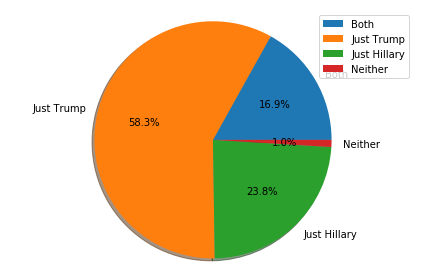

In [10]:
TOTAL = len(tweets_data)
 
labels = ['Both', 'Just Trump', 'Just Hillary', 'Neither']
sizes = [both/TOTAL, justTrump/TOTAL, justHillary/TOTAL, neither/TOTAL]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
pie = plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
plt.legend(pie[0], labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()

# Cleaning

In [7]:
# A function that removes the hyperlinks from the tweet's content.
def remove_link(tweet):
    return re.sub(r"http\S+", "", tweet)

def remove_hashtags(tweet):
    return re.sub('#', '', tweet)

def remove_entire_hashtags(tweet):
    return re.sub(r'(?:\s|^)#[A-Za-z0-9\-\.\_]+(?:\s|$)', ' ', tweet).strip()

def remove_mentions(tweet):
    return " ".join(re.sub("(?:\@|https?\://)\S+"," ",tweet).split())


def remove_non_az_characters(tweet):
    return " ".join(re.sub('[^a-zA-Z]'," ",tweet).split())

In [8]:
# https://pypi.org/project/emoji/

import emoji

def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def text_without_emojis(str):
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)

text_with_emoji = "Come to Jesus meeting!!!! What on earth is that supposed to be? 😔 https://t.co/a3lOpTtFig"
print(text_with_emoji)
print(extract_emojis(text_with_emoji))
print(text_without_emojis(text_with_emoji))

Come to Jesus meeting!!!! What on earth is that supposed to be? 😔 https://t.co/a3lOpTtFig
😔
Come to Jesus meeting!!!! What on earth is that supposed to be?  https://t.co/a3lOpTtFig


In [1]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    doc = doc.lower()
    doc = remove_link(doc)
    #print('without links:', doc)
    doc = remove_mentions(doc)
    #print('without mentions:', doc)
    #doc = text_without_emojis(doc)
    #print('without emojis:', doc)
    #doc = remove_entire_hashtags(doc)
    doc = remove_hashtags(doc)
    #print('without hashtags:', doc)
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    #print('stop free:', doc)
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #print('punc_free:', doc)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #print('normalized:', normalized)
    normalized = remove_non_az_characters(normalized)
    #print('non-az removed:', normalized)
    normalized = " ".join(word for word in normalized.split() if len(word) > 3)
    return normalized

In [9]:
clean('@remy: This is @hello waaaaayyyy too much. For you!!!!!! #angry https://google.com 😔')

'waaaaayyyy much angry'

In [14]:
for i, tweet in enumerate(tweets_data):
    tweet['cleaned_text'] = clean(tweet['text'])
    tweets_data[i] = tweet

# Tokenizing

In [ ]:
# lower-casing
# removing all URLs & mentions & stop-words & tokens that consist only of non-alphanumeric characters (no emoticons) & short tokens (<3 characters)
# filter out all non-English
# remove very long conversations (>200 tweets) to avoid excessively long documents
# filter out all re-tweets (i.e., reposting tweets posted by other users) (they serve more as an endorsement rather than an original content)

In [21]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [16]:
s1 = '@remy: This is waaaaayyyy too much. For you!!!!!! #angry https://google.com'
tknzr.tokenize(s1)

[':',
 'This',
 'is',
 'waaayyy',
 'too',
 'much',
 '.',
 'For',
 'you',
 '!',
 '!',
 '!',
 '#angry',
 'https://google.com']

In [17]:
tknzr.tokenize('remy hello waaaaayyyy much you angry 😔')

['remy', 'hello', 'waaayyy', 'much', 'you', 'angry', '😔']

# Generating training set

In [18]:
dataframe = pd.read_csv("Sentiment.csv", sep=",", index_col='id')
dataframe.head()

,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
id,,,,,,,,,,,,,,,,,,,,
1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [19]:
dataframe = dataframe[['sentiment', 'text']]
dataframe.head()

,sentiment,text
id,,
1,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
2,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
3,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
4,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
5,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [18]:
#dataframe2 = dataframe
#dataframe2['sentiment'].iloc[0] = np.array('bla')
#dataframe2['text'].iloc[0] = np.array('text bla')
#print(dataframe2.head())
#del dataframe2

In [22]:
training_set = []

for index, row in dataframe.iterrows():
    sentiment = row['sentiment']
    tweet_text = row['text']
    # cleaning
    cleaned_text = clean(tweet_text)
    # tokenizing
    tokenized_tweet = tknzr.tokenize(cleaned_text)
    
    training_set.append((tokenized_tweet, sentiment))
    

In [23]:
# Get the separate words in tweets
# Input:  A list of tweets
# Output: A list of all words in the tweets
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

# Create a dictionary measuring word frequencies
# Input: the list of words
# Output: the frequency of those words apearing in tweets
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    # print ("Word frequency list\n")
    # pprint(wordlist)
    return word_features


In [24]:
word_features = get_word_features(get_words_in_tweets(training_set))

# Construct our features based on which tweets contain which word
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

In [25]:
# Here we apply the features we constructed to our tweets data.
training_set = nltk.classify.apply_features(extract_features, training_set)

In [23]:
# Printing the resulting training set shows the features we are going to pass to the classifier.
# pprint(training_set)

In [26]:
# This is the line of code that we use to train our classifier. Training is performed in a streamlined way so no output is visible.
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [27]:
print (classifier.show_most_informative_features(32))

Most Informative Features
              imwithhuck = True           Positi : Negati =     69.6 : 1.0
                 forward = True           Positi : Negati =     35.2 : 1.0
                    imho = True           Positi : Negati =     31.6 : 1.0
               obviously = True           Negati : Positi =     28.0 : 1.0
              transcript = True           Neutra : Negati =     27.9 : 1.0
               influence = True           Negati : Positi =     27.5 : 1.0
                  makeup = True           Negati : Positi =     26.2 : 1.0
                   punch = True           Negati : Positi =     24.0 : 1.0
                    sets = True           Neutra : Negati =     22.5 : 1.0
                   icymi = True           Neutra : Negati =     22.5 : 1.0
                 raising = True           Positi : Neutra =     22.0 : 1.0
                 enjoyed = True           Positi : Neutra =     21.1 : 1.0
                   loved = True           Positi : Neutra =     19.4 : 1.0

In [28]:
# The tweet we are about to classify
tweet = 'This dish is horrible'
print (classifier.classify(extract_features(tweet.split())))

Negative


In [29]:
tweet = 'Ivo listens to horrendous electronic music'
print (classifier.classify(extract_features(tweet.split())))

Negative


## Are our tweets positive, negative or neutral?

In [30]:
NUM_TWEETS = len(tweets_data) # len(tweets_data)

In [47]:
for i, tweet in enumerate(tweets_data[197909:NUM_TWEETS]):
    if i % 10000 == 0:
        print(i)
    if 'sentiment' in tweet:
        continue
    cleanedText = tweet['cleaned_text']
    tweet['sentiment'] = classifier.classify(extract_features(cleanedText.split()))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000


In [48]:
found = False
for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    if 'sentiment' not in tweet:
        print(i)
        found = True
        break
print(found)

False


In [85]:
tweets_data = [tweet for tweet in tweets_data if tweet['cleaned_text'] != ""]

In [86]:
len(tweets_data)

607531

# Positivity - Negativity - Neutrality per state

In [87]:
positivesTweets = 0
neutralTweets = 0
negativesTweets = 0

for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    sentiment = tweet['sentiment']
    
    if sentiment == 'Positive':
        positivesTweets += 1
        s = 1
    elif sentiment == 'Negative':
        negativesTweets += 1
        s = -1
    else:  # neutral
        neutralTweets += 1
        s = 0
    tweets_data[i]['sentiment_num'] = s
print(positivesTweets, negativesTweets, neutralTweets)

mapStateToSentiment = {}
for tweet in tweets_data[:NUM_TWEETS]:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']

    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    tweet['place']['state_name'] = state
    s = tweet['sentiment_num']
    if state not in mapStateToSentiment:
        mapStateToSentiment[state] = 0
    mapStateToSentiment[state] += s
    
values = mapStateToSentiment.values()
min_sentiment = min(values)
max_sentiment = max(values)

31708 466260 109563


In [50]:
len(mapStateToSentiment.keys())

52

In [88]:
mapStateToSentiment

{'LA': -2328,
 'MD': -6393,
 'CA': -43919,
 'NJ': -11091,
 'TX': -23454,
 'MI': -6065,
 'KY': -2191,
 'IA': -2301,
 'FL': -26963,
 'MA': -8083,
 'PA': -9103,
 'VA': -6739,
 'AZ': -10117,
 'NY': -28846,
 'UT': -1622,
 'OR': -5166,
 'CT': -2764,
 'MO': -3920,
 'SC': -2665,
 'DE': -336,
 'OK': -2236,
 'IL': -12342,
 'TN': -5162,
 'KS': -1680,
 'MS': -1582,
 'NC': -6781,
 'GA': -5997,
 'OH': -8259,
 'MN': -2635,
 'WI': -2561,
 'ME': -1165,
 'CO': -4487,
 'AR': -956,
 'WA': -7293,
 'RI': -1399,
 'NV': -4840,
 'DC': -2860,
 'NE': -1165,
 'WV': -764,
 'IN': -3244,
 'HI': -1733,
 'ID': -967,
 'AL': -3524,
 'NM': -1764,
 'NH': -1265,
 'VT': -190,
 'ND': -193,
 'MT': -268,
 'SD': -250,
 'AK': -738,
 'WY': -250,
 'Mo': -1}

In [89]:
S_DIR = 'states_21basic/' 
BLUE = '#5599ff'

with open(os.path.join(S_DIR, 'states.json')) as rf:    
    data = json.load(rf)

def displayUSMap(mapp, cmap = plt.cm.inferno):
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()
    for feature in data['features']:
        geometry = feature['geometry']
        props = feature['properties']
        NAME = props['STATE_ABBR']
        POP = mapp.get(NAME,0)
        norm = matplotlib.colors.Normalize(vmin=min_sentiment, vmax=max_sentiment)
        col = cmap(norm(POP))
        #print(NAME,POP,col)
        if geometry['type'] == 'Polygon':
            poly = geometry
            ppatch = PolygonPatch(poly, fc=col, ec=col,  alpha=0.5, zorder=2)
            ax.add_patch(ppatch)
        elif geometry['type'] == 'MultiPolygon':
            for polygon in geometry['coordinates'][0]:
                poly = Polygon(polygon)
                ppatch = PolygonPatch(poly, fc=col, ec=col, alpha=0.5, zorder=2)
                ax.add_patch(ppatch)
        else:
            print('Don\'t know how to draw :', geometry['type'])

    ax.axis('scaled')
    plt.axis('off')
    plt.show()

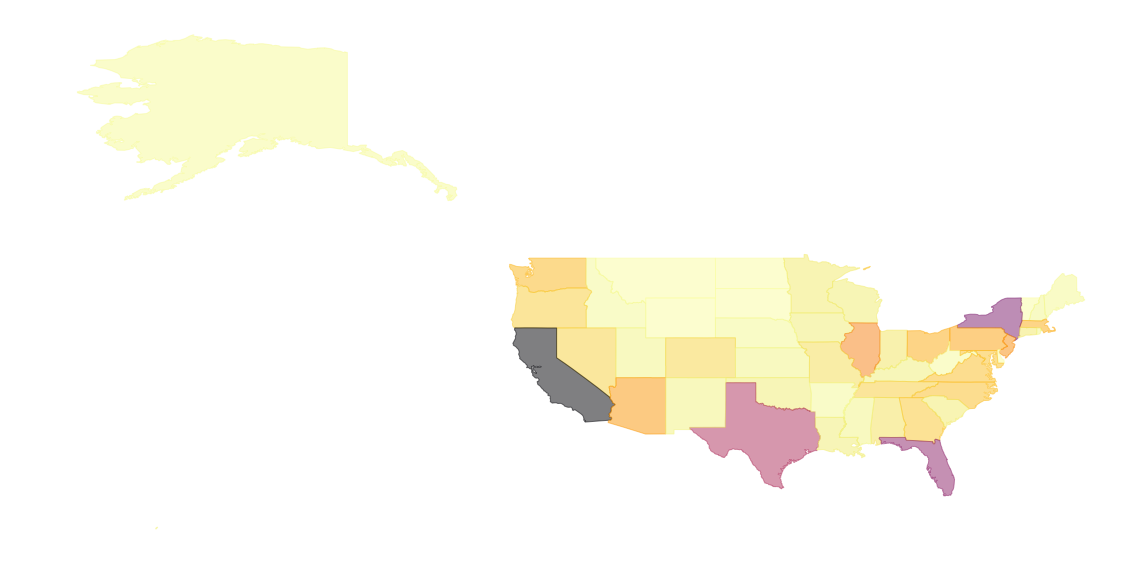

In [90]:
displayUSMap(mapStateToSentiment, plt.cm.inferno)

# Hillary vs Trump?

In [91]:
for i, tweet in enumerate(tweets_data[:NUM_TWEETS]):
    talk = tweet['talk']
    if talk == 'hillary':
        s = 1
    elif talk == 'trump':
        s = -1
    elif talk == 'both':
        s = 0
    else:  # neutral
        s = None
    tweets_data[i]['talk_num'] = s

mapStateToTalk = {}
for tweet in tweets_data[:NUM_TWEETS]:
    if tweet['place'] == None:
        continue
    countryCode = tweet['place']['country_code']
    city = tweet['place']['full_name']
    if countryCode != 'US' or ',' not in city:
        continue
    cityAndState = city.split(',')
    state = cityAndState[1].strip()
    if len(state) != 2: # skip Philadelphia
        continue
    tweet['place']['state_name'] = state
    s = tweet['talk_num']
    #print(s)
    if s == None:
        continue
    if state not in mapStateToTalk:
        mapStateToTalk[state] = 0
    
    mapStateToTalk[state] += s


values = mapStateToTalk.values()

min_talk = min(values)
max_talk = max(values)

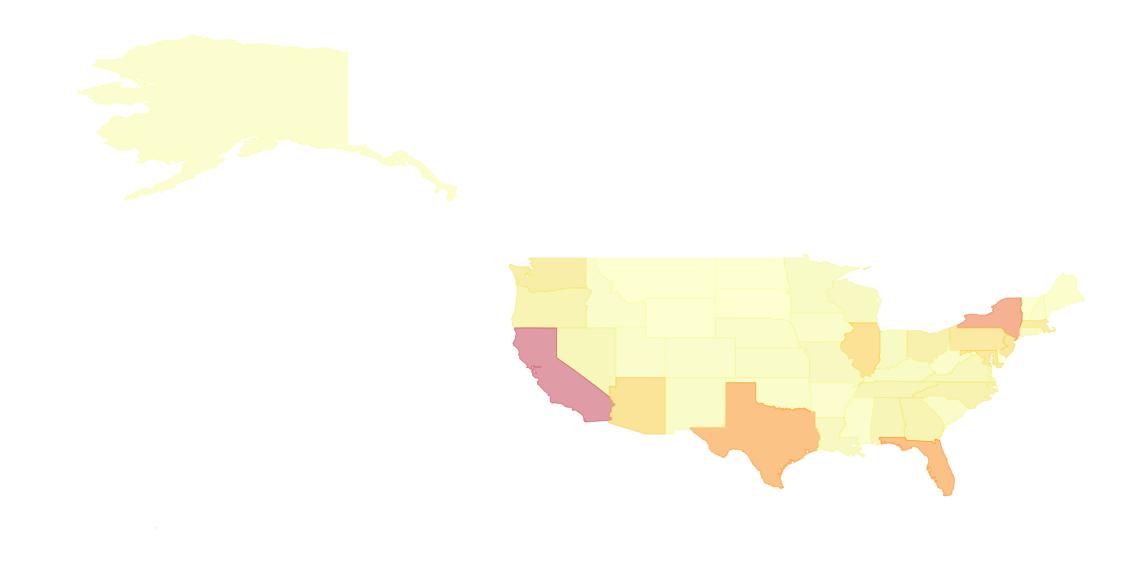

In [92]:
displayUSMap(mapStateToTalk)

In [93]:
print(min_talk, max_talk)

-20953 -1


In [94]:
mapStateToTalk

{'LA': -1388,
 'MD': -4140,
 'CA': -20953,
 'NJ': -4642,
 'TX': -11430,
 'MI': -2854,
 'KY': -1032,
 'IA': -545,
 'FL': -11692,
 'MA': -3835,
 'PA': -4307,
 'VA': -1886,
 'AZ': -5582,
 'NY': -15001,
 'UT': -666,
 'OR': -2696,
 'CT': -1295,
 'MO': -1381,
 'SC': -886,
 'DE': -119,
 'OK': -748,
 'IL': -5992,
 'TN': -2395,
 'KS': -943,
 'MS': -382,
 'NC': -2880,
 'GA': -2602,
 'OH': -3158,
 'MN': -1128,
 'WI': -1486,
 'ME': -459,
 'CO': -599,
 'AR': -219,
 'WA': -3747,
 'RI': -450,
 'NV': -1891,
 'DC': -1524,
 'NE': -732,
 'WV': -587,
 'IN': -1273,
 'HI': -1005,
 'ID': -537,
 'AL': -2272,
 'NM': -928,
 'NH': -568,
 'VT': -44,
 'ND': -75,
 'MT': -81,
 'SD': -112,
 'AK': -344,
 'WY': -62,
 'Mo': -1}

In [46]:
# import json
# 
# with open('customTweetsWithSentiment.jsons', 'w') as file:
#     for i, tweet in enumerate(tweets_data):
#         file.write(json.dumps(tweet) + '\n')

# Which kind of tweets are replied the most? (Albert) Are neutral tweet more or less likely to be replied than positive and negative tweets?

In [1]:
# tweet1 - positive = 2
# 	tweet2 - negative = 0
# 	tweet3 - negative = 1
# 		tweet4 - neutral = 1
# 			tweet6 - positive = 0
# 
# tweet5 - negative = 0

In [14]:
tweets_test = [
    {
        'id': 1,
        'in_reply_to_status_id': -1,
        'sentiment':'Positive'
    },
    {
        'id': 2,
        'in_reply_to_status_id': 1,
        'sentiment':'Negative'
    },
    {
        'id': 3,
        'in_reply_to_status_id': 1,
        'sentiment':'Negative'
    },
    {
        'id': 4,
        'in_reply_to_status_id': 3,
        'sentiment':'Neutral'
    },
    {
        'id': 6,
        'in_reply_to_status_id': 4,
        'sentiment':'Neutral'
    },
    {
        'id': 5,
        'in_reply_to_status_id': -1,
        'sentiment':'Negative'
    },
]

In [12]:
mapIdToIdx = {}
for i, tweet in enumerate(tweets_data):
    mapIdToIdx[tweet['id']] = i
def getTweetThatThisIsAnsweringTo(tweetIdToFind, tweets):
    global mapIdToIdx
    idx = mapIdToIdx.get(tweetIdToFind,None)
    return None if idx == None else tweets[idx]

mapSentimentToRepliesCount = {'Positive': 0, 'Negative': 0, 'Neutral': 0}

def f(tweet, tweets, isParent):
    id = tweet['id']
    in_reply_to_status_id = tweet['in_reply_to_status_id']
    sentiment = tweet['sentiment']
    
    parentTweet = getTweetThatThisIsAnsweringTo(in_reply_to_status_id, tweets)
    if not(parentTweet == None or isParent == True): # parent found
        f(parentTweet, tweets, True)
    elif isParent == True:
        mapSentimentToRepliesCount[sentiment] += 1
        if 'replies' in tweet:
            tweet['replies'] += 1
        else:
            tweet['replies'] = 1



In [14]:
# sha de fer tot de cop, borrar replies primer
for i, tweet in enumerate(tweets_data):
    if 'replies' in tweets_data[i]:
        del tweets_data[i]['replies']

num = len(tweets_data)

for i, tweet in enumerate(tweets_data[:num]):
    f(tweet, tweets_data[:num], False)
    if i%50000==0:
        print(i)
    
    
mapSentimentToRepliesCount

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000


{'Positive': 2654, 'Negative': 29096, 'Neutral': 6976}

In [60]:
i

202073

In [11]:
for i, tweet in enumerate(tweets_data[:num]):
    if 'replies' not in tweet:
        print(i)
        break

0


In [76]:
764042476487217152 in mapIdToIdx

False

In [78]:
mapIdToIdx.get(764042476487417152,0)

0

In [79]:
mapIdToIdx.get(764042476487217152,0)

55

In [16]:
tweets_without_reply = num - sum(mapSentimentToRepliesCount.values())
tweets_without_reply

618581

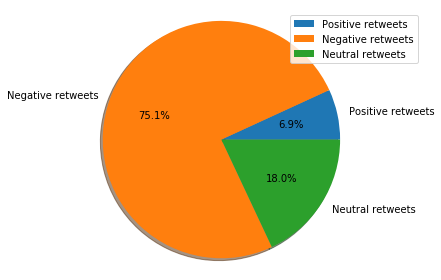

In [15]:
TOTAL = sum(mapSentimentToRepliesCount.values())
 
labels = ['Positive retweets', 'Negative retweets', 'Neutral retweets']
sizes = [mapSentimentToRepliesCount['Positive']/TOTAL, mapSentimentToRepliesCount['Negative']/TOTAL, mapSentimentToRepliesCount['Neutral']/TOTAL]
pie = plt.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%')
plt.legend(pie[0], labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()

In [84]:
sumEmptyTweets = 0
for i, tweet in enumerate(tweets_data):
    if tweet['cleaned_text'] == "":
        sumEmptyTweets += 1
sumEmptyTweets

49776